In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
from random import random

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        actions = Q[observation]
        greedy_action = np.argmax(actions)
        # greedy means everything on best action
        return [1 if i == greedy_action else 0 for i in range(0, len(actions))]
    
    return policy_fn

In [7]:
def select_action(actions):
    r = random()
    action = -1
    total = 0
    for i, prob in enumerate(actions):
        if r < prob + total:
            action = i
            break
        total = total + prob
    assert action > -1
    
    return action

def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # cumulative sum of weights
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i_episode  in range(0, num_episodes):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        observation = env.reset()
        episode = [] # keep track of states visited
        for t in range(100):
            action_list = behavior_policy(observation)
            action = select_action(action_list)
            assert action > -1
            assert action < len(action_list)
            
            next_observation, reward, done, _ = env.step(action)
            # score, dealer_score, usable_ace = observation
            
            # save s_t, A_t, and R_{t+1}
            episode.append((observation, action, reward))
            
            if done:
                # The final state is of no interest, only the final reward.
                break
            
            observation = next_observation
        
        # algorithm page 111
        G = 0
        W = 1
        for (observation, action, reward) in reversed(episode):
            G = G + reward
            C[observation][action] = C[observation][action] + W
            assert C[observation][action] != 0
            
            Q[observation][action] = Q[observation][action] +\
                (W/C[observation][action])*(G - Q[observation][action])
            assert behavior_policy(observation)[action] != 0
            
            action_target = np.argmax(target_policy(observation))
            if(action_target == action):
                # This rule makes the monte carlo method rather
                # slow when the behavior policy is very different
                # from the target policy.
                break
            
            W = W/(behavior_policy(observation)[action])
        
    return Q, target_policy

In [8]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 499000/500000.

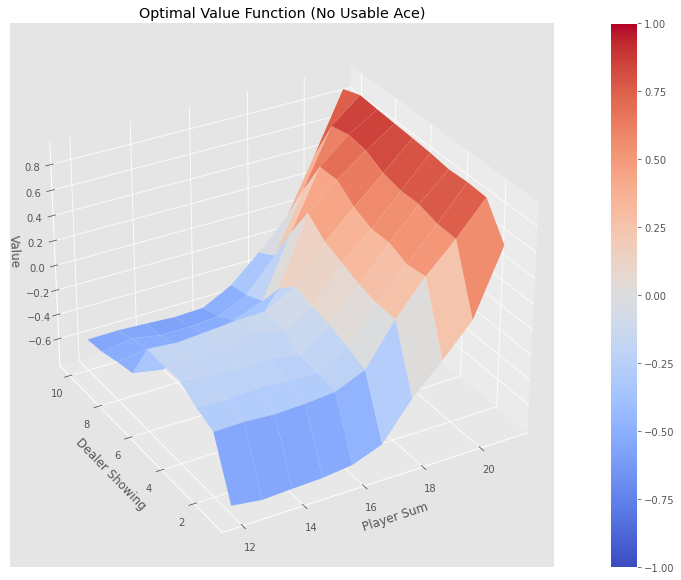

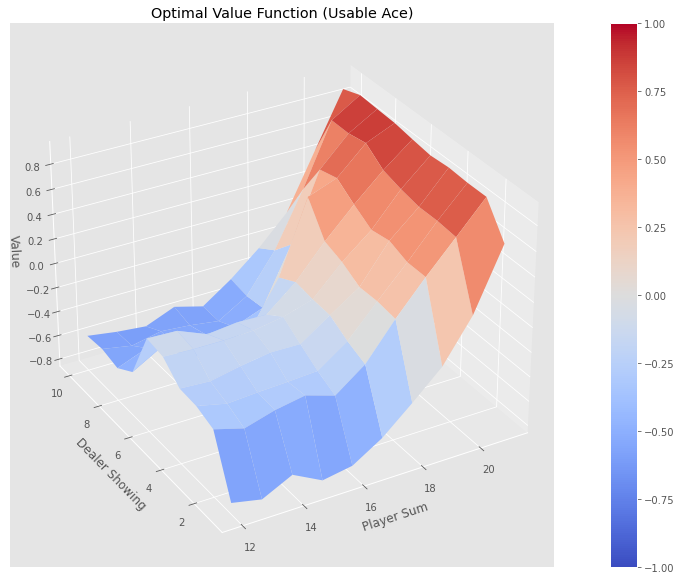

In [9]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")